In [34]:
from transformers import CLIPProcessor, CLIPModel
import torch
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np
import tarfile
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode, decode_jpeg
from sache import SpecifiedHookedViT

In [25]:
def create_random_image(width, height, mode='RGB'):
    """
    Creates a new PIL Image with random pixels.

    :param width: Width of the image in pixels.
    :param height: Height of the image in pixels.
    :param mode: Color mode of the image. Common modes include 'RGB', 'RGBA', 'L' (grayscale).
    :return: PIL Image object with random pixels.
    """
    if mode == 'RGB':
        # For RGB, we need three channels
        array = np.random.randint(0, 256, (height, width, 3), dtype='uint8')
    elif mode == 'RGBA':
        # For RGBA, we need four channels
        array = np.random.randint(0, 256, (height, width, 4), dtype='uint8')
    elif mode == 'L':
        # For grayscale, we need one channel
        array = np.random.randint(0, 256, (height, width), dtype='uint8')
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    # Create the image from the array
    image = Image.fromarray(array, mode)
    return image


In [29]:
img = create_random_image(64, 64, mode='RGB')

img_bytes = io.BytesIO()
img.save(img_bytes, format='JPEG')
img_data = img_bytes.getvalue()



In [41]:
tar = '../vitact/test/tars/00001-1200-1500.70.ready.tar'

with tarfile.open(tar, 'r') as tar:
    for member in tar:
        if member.isfile() and member.name.lower().endswith('.jpg'):
            with tar.extractfile(member) as file_obj:
                try:
                    img_bytes = file_obj.read()
                    tensor_bytes = torch.frombuffer(img_bytes, dtype=torch.uint8)
                    image = decode_jpeg(tensor_bytes, mode=ImageReadMode.RGB)
                except:
                    print(member, 'error')

<TarInfo '00001-1200-1500--1239.jpg' at 0x7fa89a25d540> error
<TarInfo '00001-1200-1500--1245.jpg' at 0x7fa89a25e5c0> error
<TarInfo '00001-1200-1500--1253.jpg' at 0x7fa89a25cf40> error


In [32]:
tensor_bytes = torch.frombuffer(img_data, dtype=torch.uint8)
image = decode_jpeg(tensor_bytes, mode=ImageReadMode.RGB)


In [23]:
with open('cruft/img.jpeg', 'rb') as f:
    by = f.read()
    print(by)
    tensor_bytes = torch.frombuffer(by, dtype=torch.uint8)
    image = decode_jpeg(tensor_bytes, mode=ImageReadMode.RGB)


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x10\x12\x12\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x17\x15\x15\x15\x15\x15\x15\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x15\x10\x0f\x1a-\x1d\x15\x1d--/---++----++7--------------++---+--+----+---+-77\xff\xc0\x00\x11\x08\x00\x9f\x01>\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\x06\x07\xff\xc4\x00B\x10\x00\x02\x01\x02\x01\x08\x07\x05\x06\x05\x01\t\x00\x00\x00\x00\x00\x01\x02\x03\x11\x12\x04!1AQa\x81\x91\x13Rq\xa1\xb1\xd1\xf0\x05"b\xc1\xe1\x06\x14B\x82\x92\xd2\x15#r\xa2\xf123Scs\x83\x93\xb2\xb3\xc2\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\xff\xc4\x00\x1f\x11\x01\x01\x01\x01\x01\x01\x00\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x11\x01\x12\x02\x03!1Aaq2

In [4]:
def print_stats(tensor):
    if tensor.dtype is not torch.float32:
        print('cannot print stats for non-float32 tensor')
    else:
        print('mean', round(tensor.mean().item(), 4), 'std', round(tensor.std().item(), 4), 'min', round(tensor.min().item(), 4), 'max', round(tensor.max().item(), 4))

In [5]:
model_name ='laion/CLIP-ViT-L-14-laion2B-s32B-b82K'
processor = CLIPProcessor.from_pretrained(model_name)
transform = transforms.ToTensor()

In [6]:
hook_locations = [
    (2, 'resid'),
    (20, 'resid'),
]
transformer = SpecifiedHookedViT(hook_locations, model_name, device='cuda')

In [46]:
img = Image.open('cruft/img.jpeg')
img2 = read_image('cruft/img.jpeg', mode=ImageReadMode.RGB)
with open('cruft/img.jpeg', 'rb') as f:
    tensor_bytes = torch.frombuffer(f.read(), dtype=torch.uint8)

img3 = decode_jpeg(tensor_bytes, mode=ImageReadMode.RGB)
img4 = (transforms.ToTensor()(img) * 255).to(torch.uint8)

In [20]:
q  = processor(images=img3, text = "", return_tensors="pt", padding = True)
print('Image.open')
print_stats(q['pixel_values'])

Image.open
mean 0.0253 std 0.3914 min -1.0 max 0.6863


In [8]:
q  = processor(images=img, text = "", return_tensors="pt", padding = True)
print('Image.open')
print_stats(q['pixel_values'])

Image.open
mean 0.0253 std 0.3914 min -1.0 max 0.6863


In [14]:
q  = processor(images=img2, text = "", return_tensors="pt", padding = True)
print('read_image')
print_stats(q['pixel_values'])

read_image
mean 0.0253 std 0.3914 min -1.0 max 0.6863


In [47]:
q  = processor(images=img4, text = "", return_tensors="pt", padding = True)
print('read_image')
print_stats(q['pixel_values'])

read_image
mean 0.0253 std 0.3914 min -1.0 max 0.6863


In [13]:
o1 = transformer.all_activations(it1.unsqueeze(0).cuda())
o2 = transformer.all_activations(it2.unsqueeze(0).cuda())
o3 = transformer.all_activations(it3.unsqueeze(0).cuda())


Image.open
mean 0.0488 std 0.1851 min -2.4081 max 1.9263
read_image
mean 0.1154 std 0.2346 min -2.2912 max 2.3887
mouse read_image
mean 0.1333 std 0.2367 min -2.6984 max 2.0335
imag.open and read_image 0.555884838104248
mouse and dock read_image 0.37420564889907837


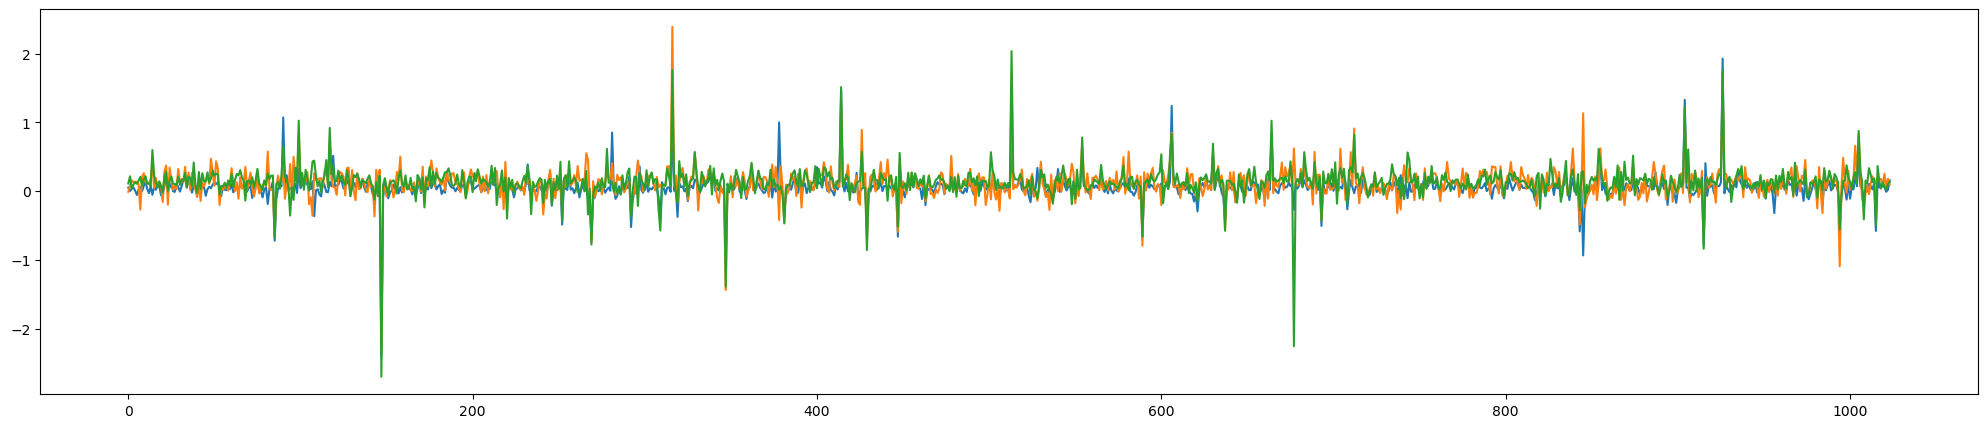

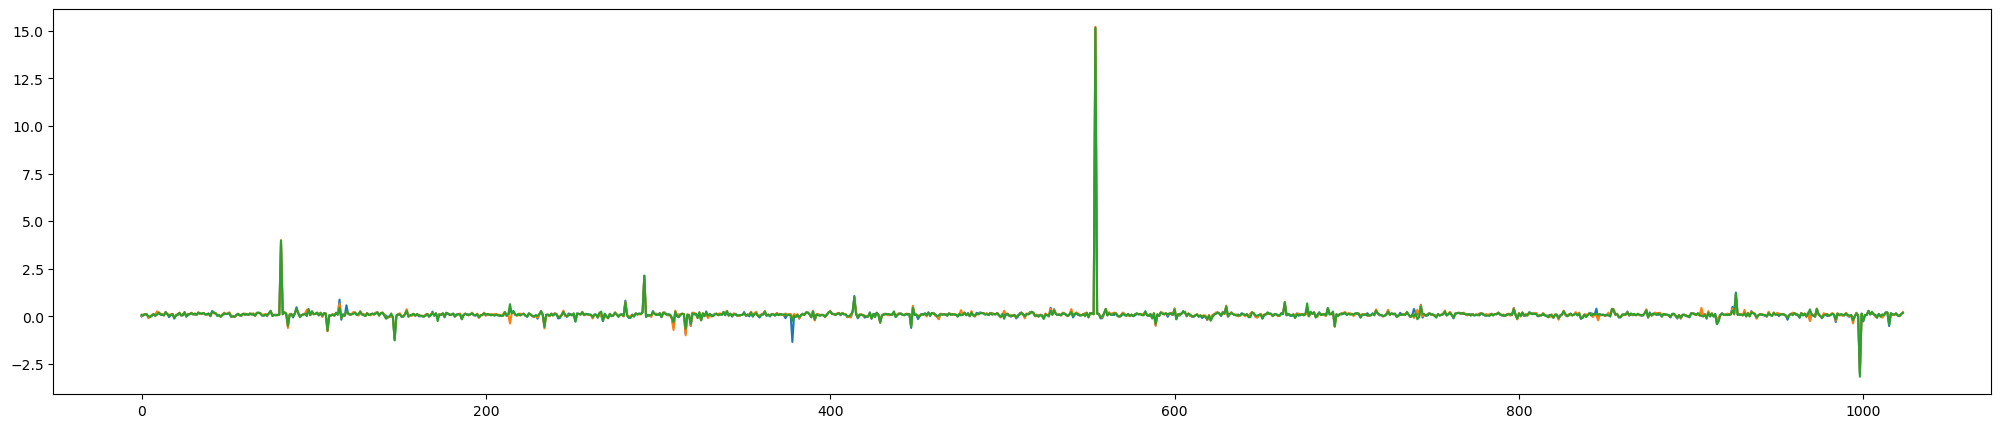

In [14]:
location = (2, 'resid')
print('Image.open')
print_stats(o1[location][0, 1])
print('read_image')
print_stats(o2[location][0, 1])
print('mouse read_image')
print_stats(o3[location][0, 1])

cos = torch.nn.functional.cosine_similarity(o1[location], o2[location], dim=-1)
print('imag.open and read_image', cos.mean().item())
cos = torch.nn.functional.cosine_similarity(o2[location], o3[location], dim=-1)
print('mouse and dock read_image', cos.mean().item())

plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 1].cpu().detach().numpy())
plt.plot(o2[location][0, 1].cpu().detach().numpy())
plt.plot(o3[location][0, 1].cpu().detach().numpy())


plt.show()


plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 0].cpu().detach().numpy())
plt.plot(o2[location][0, 0].cpu().detach().numpy())
plt.plot(o3[location][0, 0].cpu().detach().numpy())


plt.show()

# show cosine similarity between o1[location] and o2[location]




Image.open
mean 0.1352 std 0.4144 min -1.7887 max 2.362
read_image
mean 0.1958 std 0.5486 min -8.0049 max 3.5242
mouse read_image
mean 0.2147 std 0.6345 min -5.3257 max 8.9155
imag.open and read_image 0.36705198884010315
mouse and dock read_image 0.24804382026195526


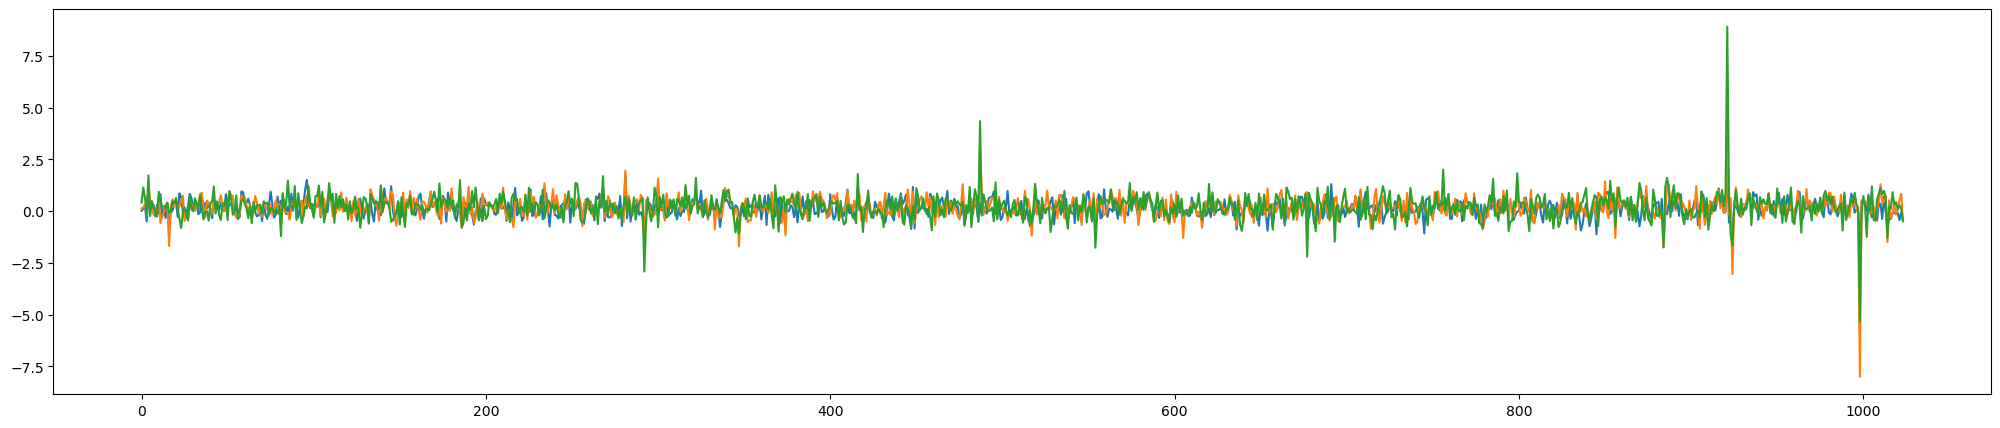

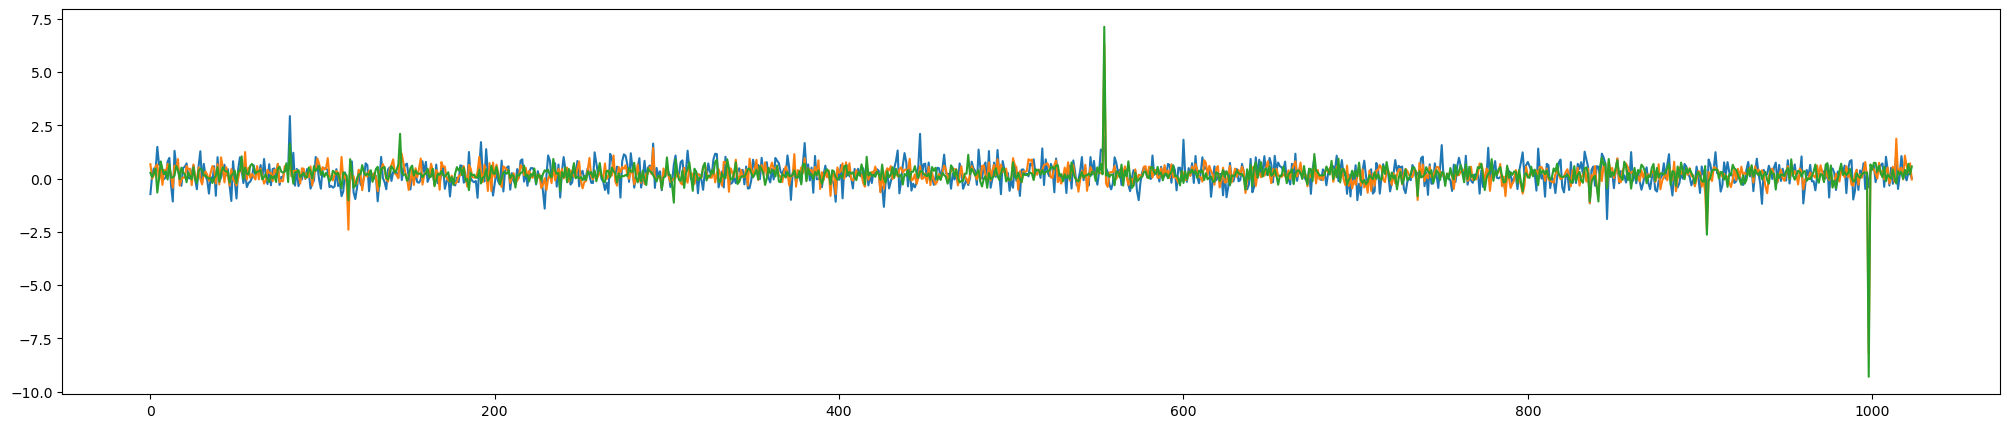

In [15]:
location = (20, 'resid')
print('Image.open')
print_stats(o1[location][0, 1])
print('read_image')
print_stats(o2[location][0, 1])
print('mouse read_image')
print_stats(o3[location][0, 1])

cos = torch.nn.functional.cosine_similarity(o1[location], o2[location], dim=-1)
print('imag.open and read_image', cos.mean().item())
cos = torch.nn.functional.cosine_similarity(o2[location], o3[location], dim=-1)
print('mouse and dock read_image', cos.mean().item())

plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 1].cpu().detach().numpy())
plt.plot(o2[location][0, 1].cpu().detach().numpy())
plt.plot(o3[location][0, 1].cpu().detach().numpy())


plt.show()


plt.figure(figsize=(25, 5))

plt.plot(o1[location][0, 0].cpu().detach().numpy())
plt.plot(o2[location][0, 0].cpu().detach().numpy())
plt.plot(o3[location][0, 0].cpu().detach().numpy())


plt.show()

# show cosine similarity between o1[location] and o2[location]




In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch

In [3]:
files = [
    '../vitact/cruft/2_resid_29c579.jsonl',
    '../vitact/cruft/20_resid_5998fd.jsonl',
]
infos = []
for file in files:
    rows = []
    with open(file) as f:
        lines = f.readlines()
        for l in lines:
            rows.append(json.loads(l))


    info = defaultdict(list)
    info['name'] = file

    for row in rows:
            for k in ['mbps', 'enc', 'dec', 'enc_b', 'dec_b', 'delta_hist', 'input_hist', 'reconstruction_hist', 'current_k',
                    'latent_hist', 'rmse', 'mse', 'sum_mse', 'scaled_mse', 'input_mean', 'input_std', 'L0', 'L1', 'loss', 'dead_feature_prop', 'dead_latent_pct',
                    'experts_chosen_hist', 'enc_hist', 'dec_hist', 
                    'enc_grad_hist', 'dec_grad_hist', 'router_grad_hist', 'pre_grad_hist',
                    'pos_mask',
                    'position_mse', 'ma_count', 'massive_activations'
                    
                    ]:
                if k in row:
                    info[k].append(row[k])


    infos.append(info)

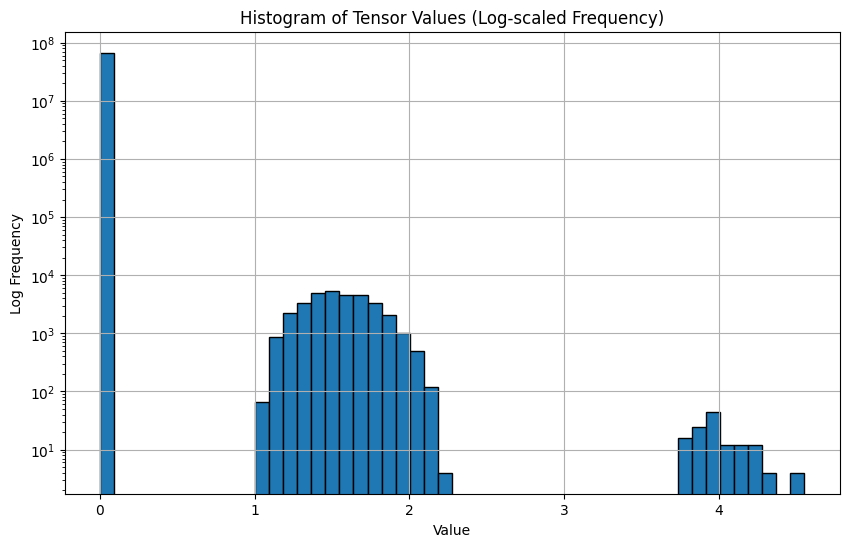

67119064.0
67115672.0
67115216.0
67115179.0
67115075.0
67115271.0
67115435.0
67115554.0
67115350.0
67115484.0


In [48]:
i = 101
info = infos[0]
h = info['latent_hist']
hist = np.array(h[i]['counts'])
edges = np.array(h[i]['edges'])

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')  # Plot histogram
plt.grid()
# Apply a logarithmic scale to exaggerate lower frequencies and downplay higher ones
plt.yscale('log')

# Labeling the axes
plt.xlabel('Value')
plt.ylabel('Log Frequency')  # Indicate that y-axis is log-scaled
plt.title('Histogram of Tensor Values (Log-scaled Frequency)')

# Show the plot
plt.show()

for i in range(0, 5000, 500):
    print(sum(h[i]['counts']))

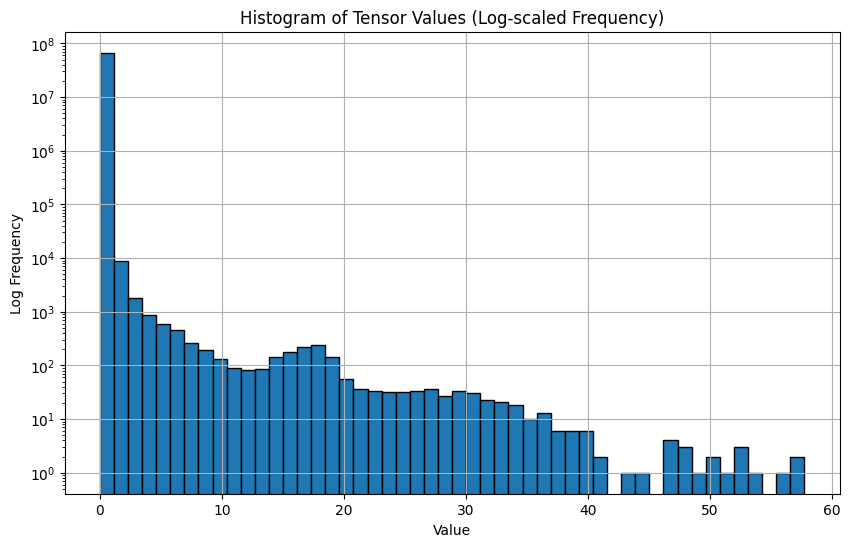

67117072.0


In [37]:
i = 4000
info = infos[1]
h = info['latent_hist']
hist = np.array(h[i]['counts'])
edges = np.array(h[i]['edges'])

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')  # Plot histogram

# Apply a logarithmic scale to exaggerate lower frequencies and downplay higher ones
plt.yscale('log')
plt.grid()
# Labeling the axes
plt.xlabel('Value')
plt.ylabel('Log Frequency')  # Indicate that y-axis is log-scaled
plt.title('Histogram of Tensor Values (Log-scaled Frequency)')

# Show the plot
plt.show()

print(sum(h[i]['counts']))


In [39]:
for i in range(0, 5000, 500):
    print(sum(h[i]['counts']))

67123460.0
67120443.0
67118349.0
67116162.0
67116619.0
67115192.0
67117337.0
67117799.0
67117072.0
67114609.0


In [51]:
a = torch.rand(65536, 1024)

bins=50
counts = torch.histc(a, bins=bins, min=float(a.min()), max=float(a.max()))


print(counts.shape, counts.sum())

torch.Size([50]) tensor(67108864.)
